In [1]:
#import standard libraries
import os
import warnings
import gc


#import datascience libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler




#import model 


pd.set_option('display.max_rows', None) 
warnings.filterwarnings(action = 'ignore')

In [2]:
#load datset
test_identity = pd.read_csv("../dataset/test_identity.csv")
test_transaction = pd.read_csv("../dataset/test_transaction.csv")

train_identity = pd.read_csv("../dataset/train_identity.csv")
train_transaction = pd.read_csv("../dataset/train_transaction.csv")


In [3]:
train_df = pd.merge(left=train_transaction,right=train_identity,how ='left', on = 'TransactionID')

In [4]:
# %run DataPrepare.ipynb

In [5]:
#reduce the memory usage of train_set
# Reduce_Memory_Usage(data = train_set)

In [6]:
del train_identity, train_transaction
gc.collect()

0

 <h1>get the categorical features and continuous features</h1>

In [7]:
# 类别、离散特征
cate_col_list = ['ProductCD','P_emaildomain','R_emaildomain','DeviceType','DeviceInfo','addr1','addr2']

#循环加入特征
for i in range(1,7):
    cate_col_list.append('card' + str(i))
for i in range(1 ,10):
    cate_col_list.append('M' + str(i))
for i in range(12 ,39):
    cate_col_list.append('id_' + str(i // 10) + str(i % 10))
#连续型特征
continual_col_list = [x for x in train_df.columns if x not in cate_col_list]
continual_col_list.remove('isFraud')

In [8]:
%run EDA_utils.ipynb

<hr style="height:2px;border-width:0;color:gray;background-color:balck"/>

## ProductCD

product code, the product for each transaction

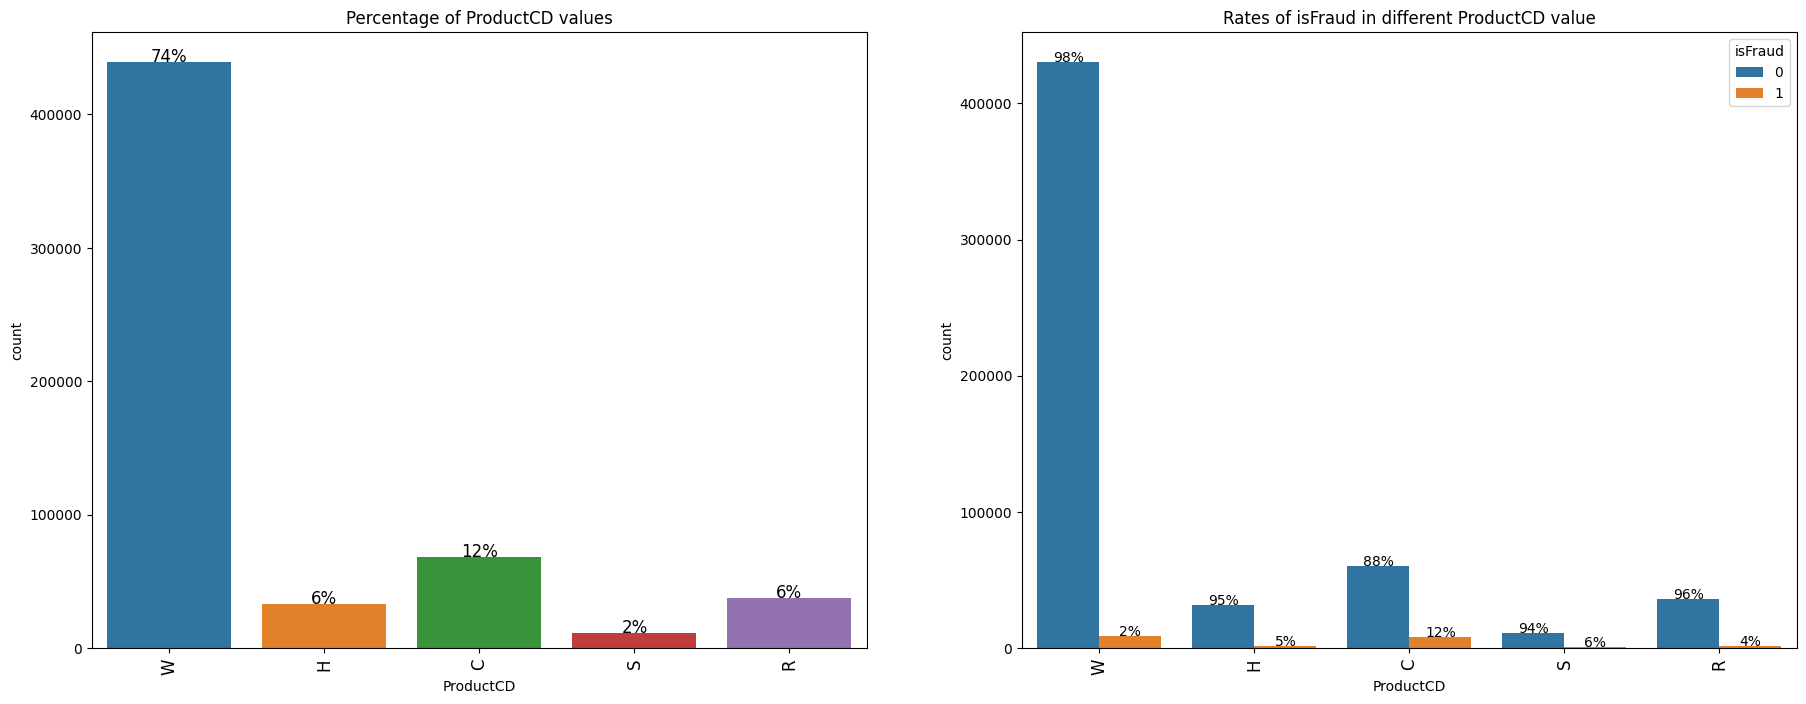

In [9]:
Plot_Cate_Feature(data = train_df, col = 'ProductCD', corr_col='isFraud')

In [10]:
train_df['ProductCD'].isnull().sum()

0

<hr style="height:2px;border-width:0;color:gray;background-color:balck">

## P_emaildomain

purchaser and recipient email domain

this feature has many values, so we should do some process firstly

In [11]:
%run EDA_utils.ipynb

The total Nan amount is 94456
The Nan rate is 16%


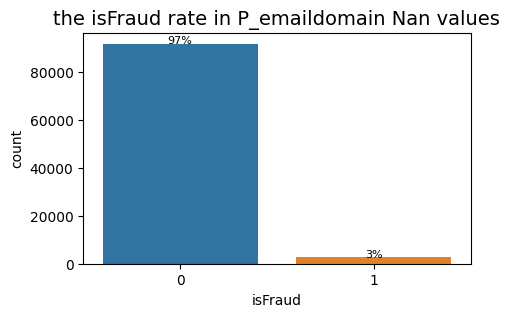

In [12]:
Plot_Feature_Nan_Rate(data = train_df, col = 'P_emaildomain', label = 'isFraud')

There are alse some Nan values in "P_emaildomain" column and isFraud rate is 3%

In [13]:
 #if copy() is not used, origin data set will be modification
temp_df = train_df.loc[:,['P_emaildomain','isFraud']].copy()

In [14]:
col_list = temp_df['P_emaildomain'].value_counts()[temp_df['P_emaildomain'].value_counts() < 1000]

In [15]:
temp_df['P_emaildomain'] = temp_df['P_emaildomain'].apply(lambda x : 'other' if x in list(col_list.index)  else x)

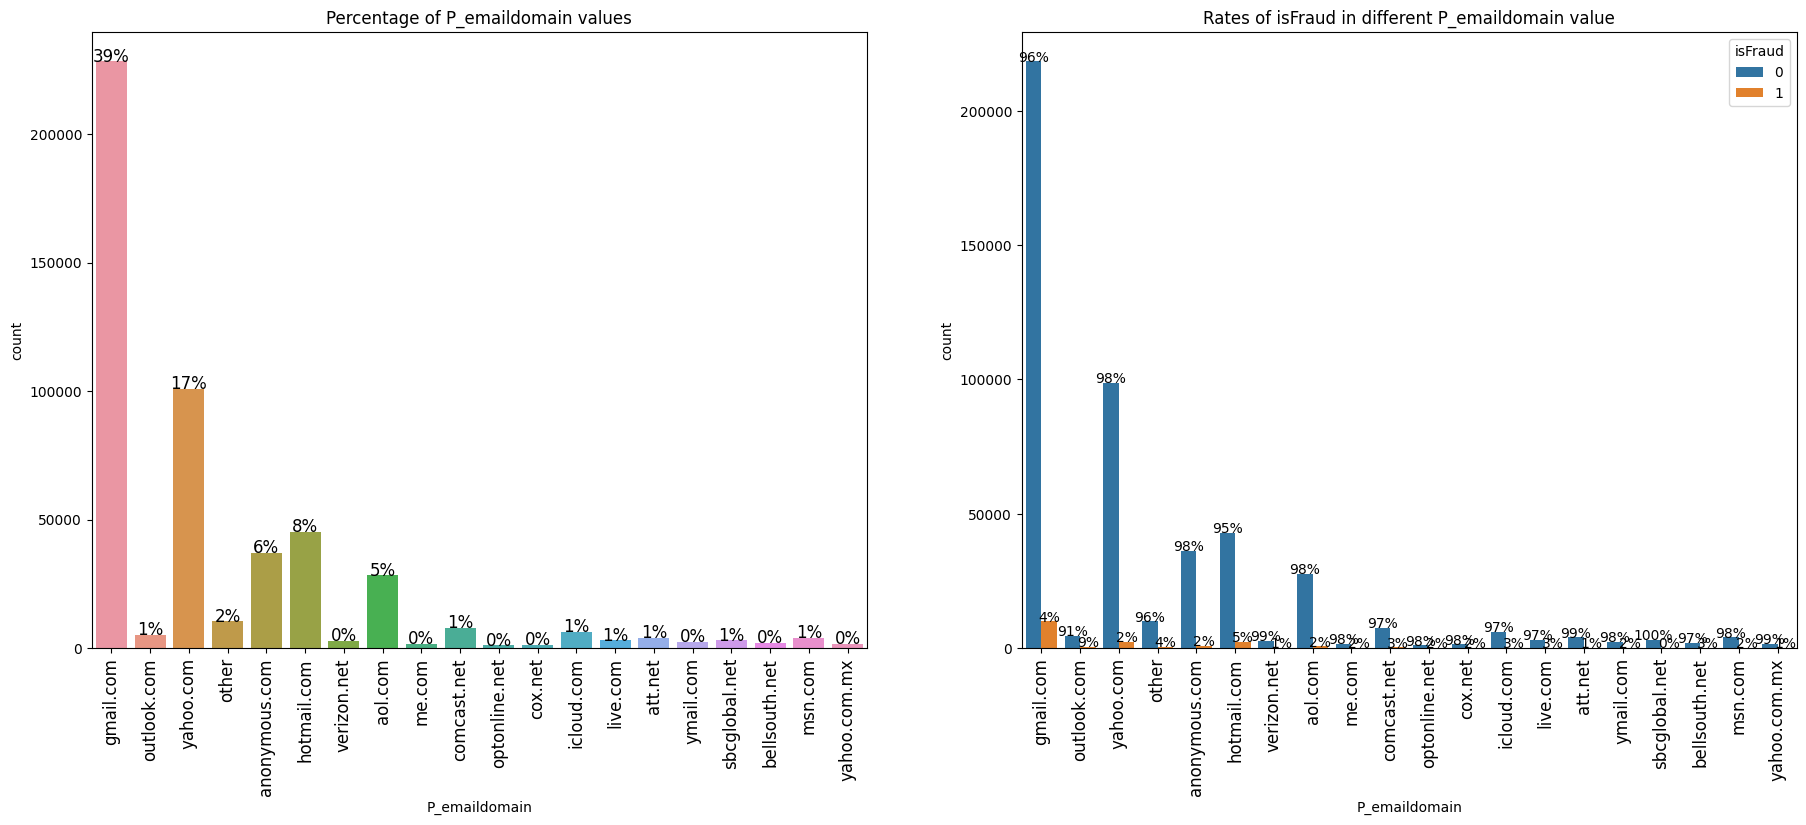

In [16]:
Plot_Cate_Feature(data = temp_df, col='P_emaildomain',corr_col='isFraud')

After classifying these value whose counts less than 1000 as 'other', distribution and isFraud rate images are above
- note that user who users outlook email has a high probability of fraud
- after classifying as 'other',   these users just has a fraud percentage of 4%

In [17]:
del temp_df
gc.collect()

17099

<hr style="height:2px;border-width:0;color:gray;background-color:balck">

## R_emaildomain

purchaser and recipient email domain

this feature has many values, so we should do some process firstly

The total Nan amount is 453249
The Nan rate is 77%


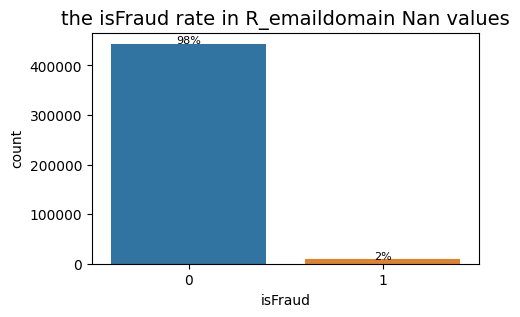

In [18]:
Plot_Feature_Nan_Rate(data = train_df, col ='R_emaildomain', label = 'isFraud')

In [19]:
#get a data copy
temp_df = train_df.loc[:,['R_emaildomain', 'isFraud']].copy()

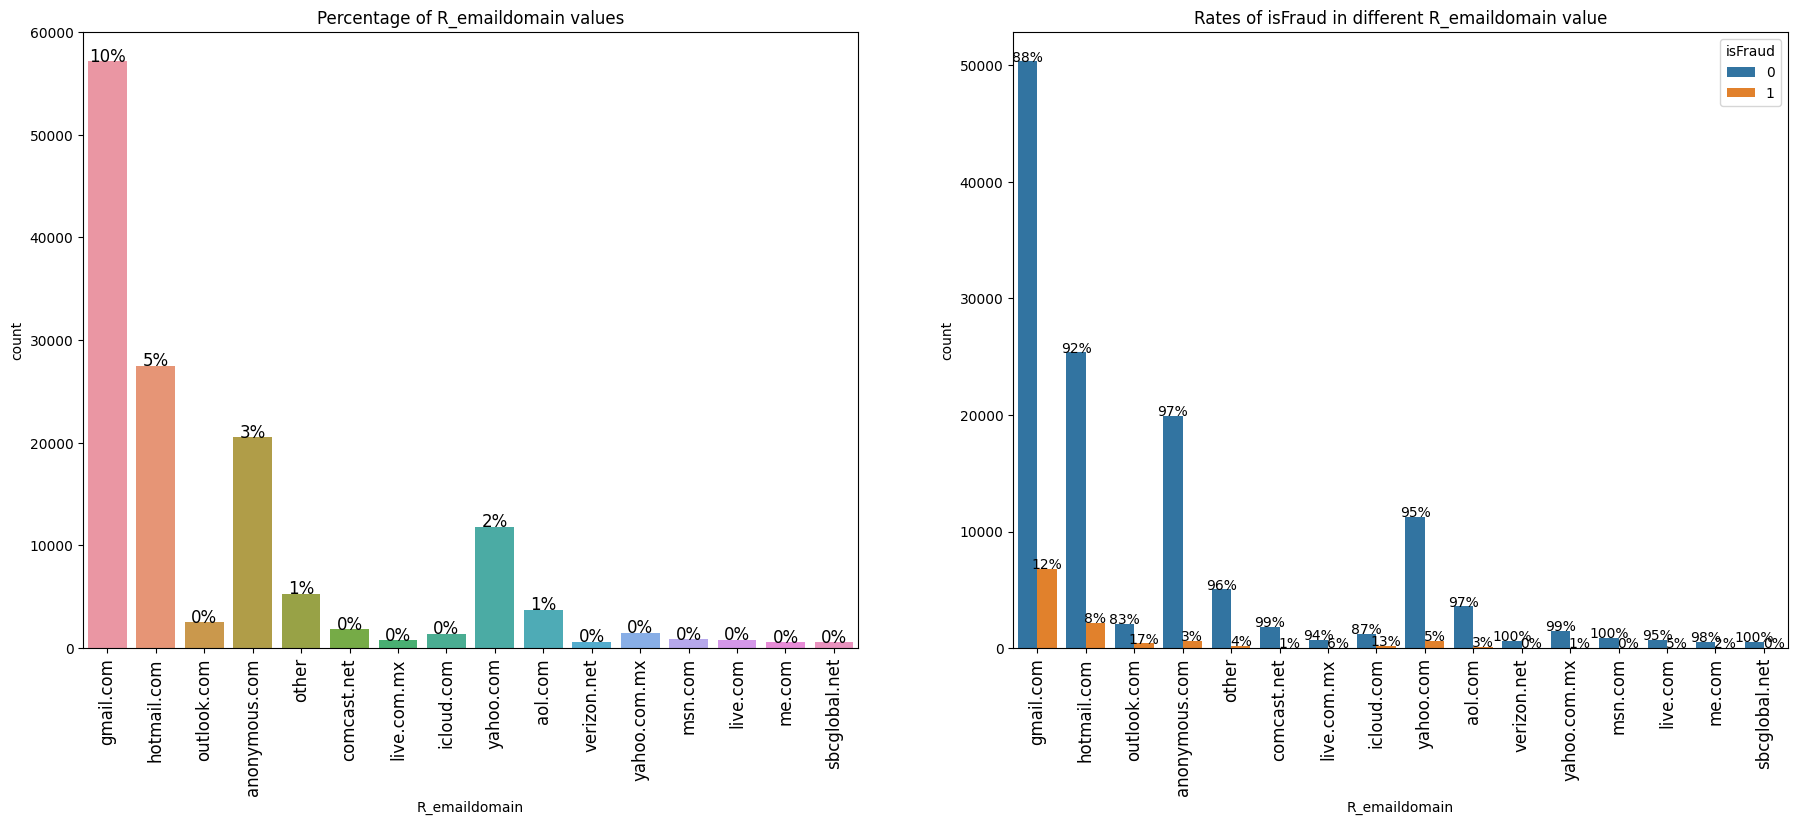

15292

In [20]:
%run EDA_utils.ipynb
col_list = temp_df['R_emaildomain'].value_counts()[temp_df['R_emaildomain'].value_counts() < 500]
temp_df["R_emaildomain"] = temp_df['R_emaildomain'].apply(lambda x : 'other' if x in list(col_list.index) else x)
Plot_Cate_Feature(data = temp_df, col='R_emaildomain', corr_col='isFraud')

del temp_df, col_list
gc.collect()

After classifying value whose count less than 500 as 'other', distribution and isfraud rate images are above
- the <b>'other'</b> take a small percentage of total not Nan values
- users who use <b>outlook</b> email may has a high rate of fraud

<hr style="height:2px;border-width:0;color:gray;background-color:balck">

## DeviceType



The total Nan amount is 449730
The Nan rate is 76%


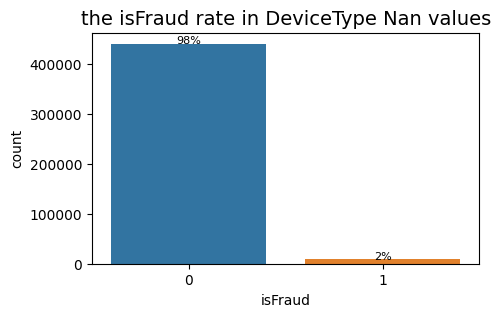

In [21]:
Plot_Feature_Nan_Rate(data = train_df,col = 'DeviceType', label='isFraud')

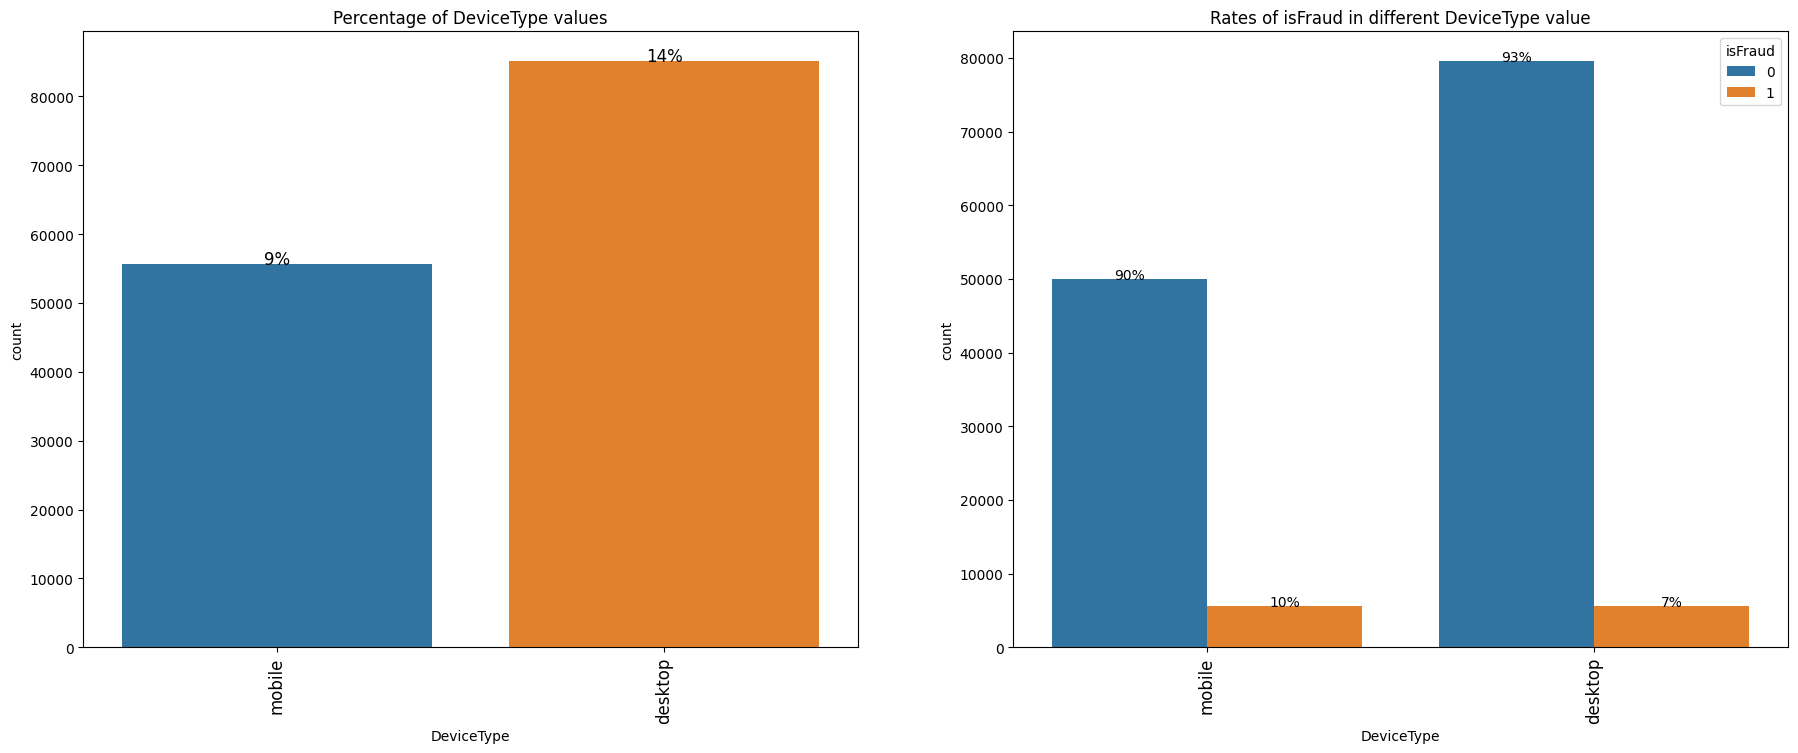

In [22]:
Plot_Cate_Feature(data = train_df, col = 'DeviceType',corr_col='isFraud')

Nothing important to find

<hr style="height:2px;border-width:0;color:gray;background-color:balck">

## DeviceInfo



The total Nan amount is 471874
The Nan rate is 80%


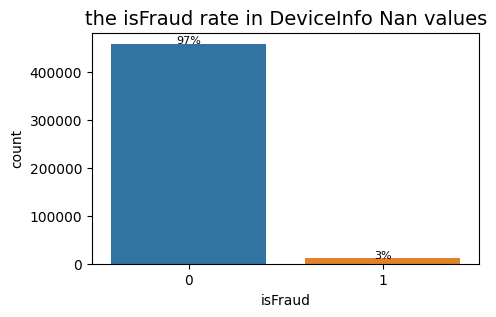

In [23]:
Plot_Feature_Nan_Rate(data = train_df, col = 'DeviceInfo', label = 'isFraud')

DeviceInfo has many values, so it need to be processed firstly

In [24]:
train_df['DeviceInfo'].value_counts()

Windows                                        47722
iOS Device                                     19782
MacOS                                          12573
Trident/7.0                                     7440
rv:11.0                                         1901
rv:57.0                                          962
SM-J700M Build/MMB29K                            549
SM-G610M Build/MMB29K                            461
SM-G531H Build/LMY48B                            410
rv:59.0                                          362
SM-G935F Build/NRD90M                            334
SM-G955U Build/NRD90M                            328
SM-G532M Build/MMB29T                            316
ALE-L23 Build/HuaweiALE-L23                      312
SM-G950U Build/NRD90M                            290
SM-G930V Build/NRD90M                            274
rv:58.0                                          269
rv:52.0                                          256
SAMSUNG                                       

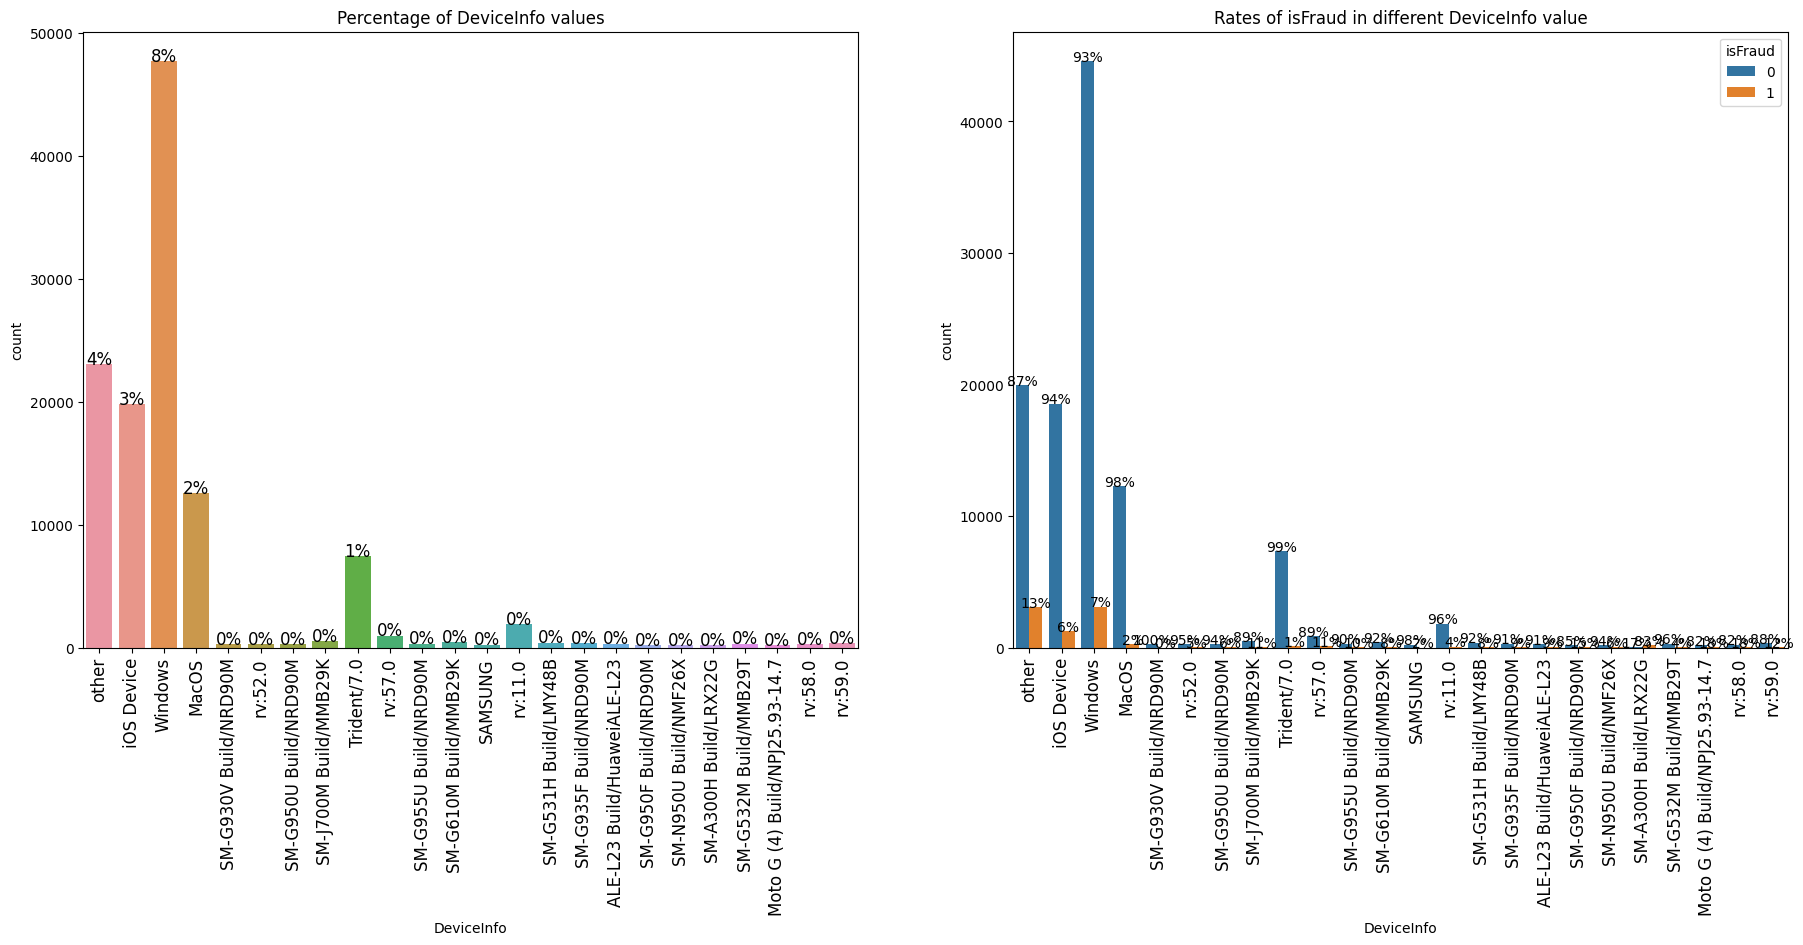

19222

In [25]:
col_list = train_df['DeviceInfo'].value_counts()[train_df['DeviceInfo'].value_counts() < 200]
temp_df = train_df.loc[:,['DeviceInfo','isFraud']].copy()
temp_df['DeviceInfo'] = temp_df['DeviceInfo'].apply(lambda x : 'other' if x in list(col_list.index) else x)
Plot_Cate_Feature(data = temp_df, col = 'DeviceInfo', corr_col='isFraud')

del col_list, temp_df
gc.collect()

if we classify these values whose total amount less than 200 or 500 as <b>other</b>, its fraud rate will come to the first place

- its a relatively important feature, and we should pay attention to it late

## addr1

addr1 may be the billing region or country which cousumption

The total Nan amount is 65706
The Nan rate is 11%


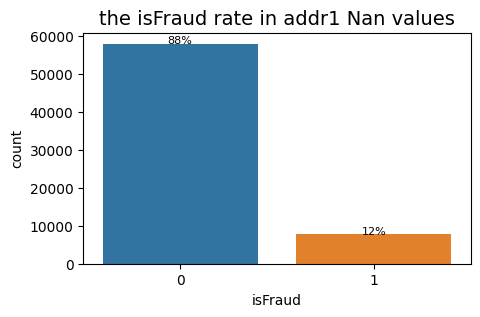

In [26]:
Plot_Feature_Nan_Rate(data = train_df, col = 'addr1', label='isFraud')

In [27]:
train_df['addr1'].value_counts()

299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
315.0    23078
441.0    20827
272.0    20141
123.0    16105
126.0    15243
184.0    15160
337.0    15149
191.0    14979
181.0    13856
143.0     9806
476.0     9478
310.0     8486
472.0     8478
327.0     8425
512.0     8268
387.0     8187
433.0     7831
231.0     7605
485.0     6816
269.0     6404
205.0     5725
225.0     5323
251.0     5216
494.0     5065
220.0     5041
226.0     4867
498.0     4744
177.0     4674
203.0     3808
420.0     3581
110.0     3220
436.0     3169
469.0     2940
324.0     2173
444.0     2033
170.0     2001
343.0     1734
384.0     1670
122.0     1617
194.0     1572
158.0     1562
428.0     1425
308.0     1279
253.0     1058
492.0      987
448.0      923
502.0      835
284.0      773
465.0      503
161.0      421
296.0      367
130.0      342
536.0      309
157.0      169
511.0      157
418.0      101
148.0       96
356.0       90
348.0       85
242.0       84
508.0       70
254.0     

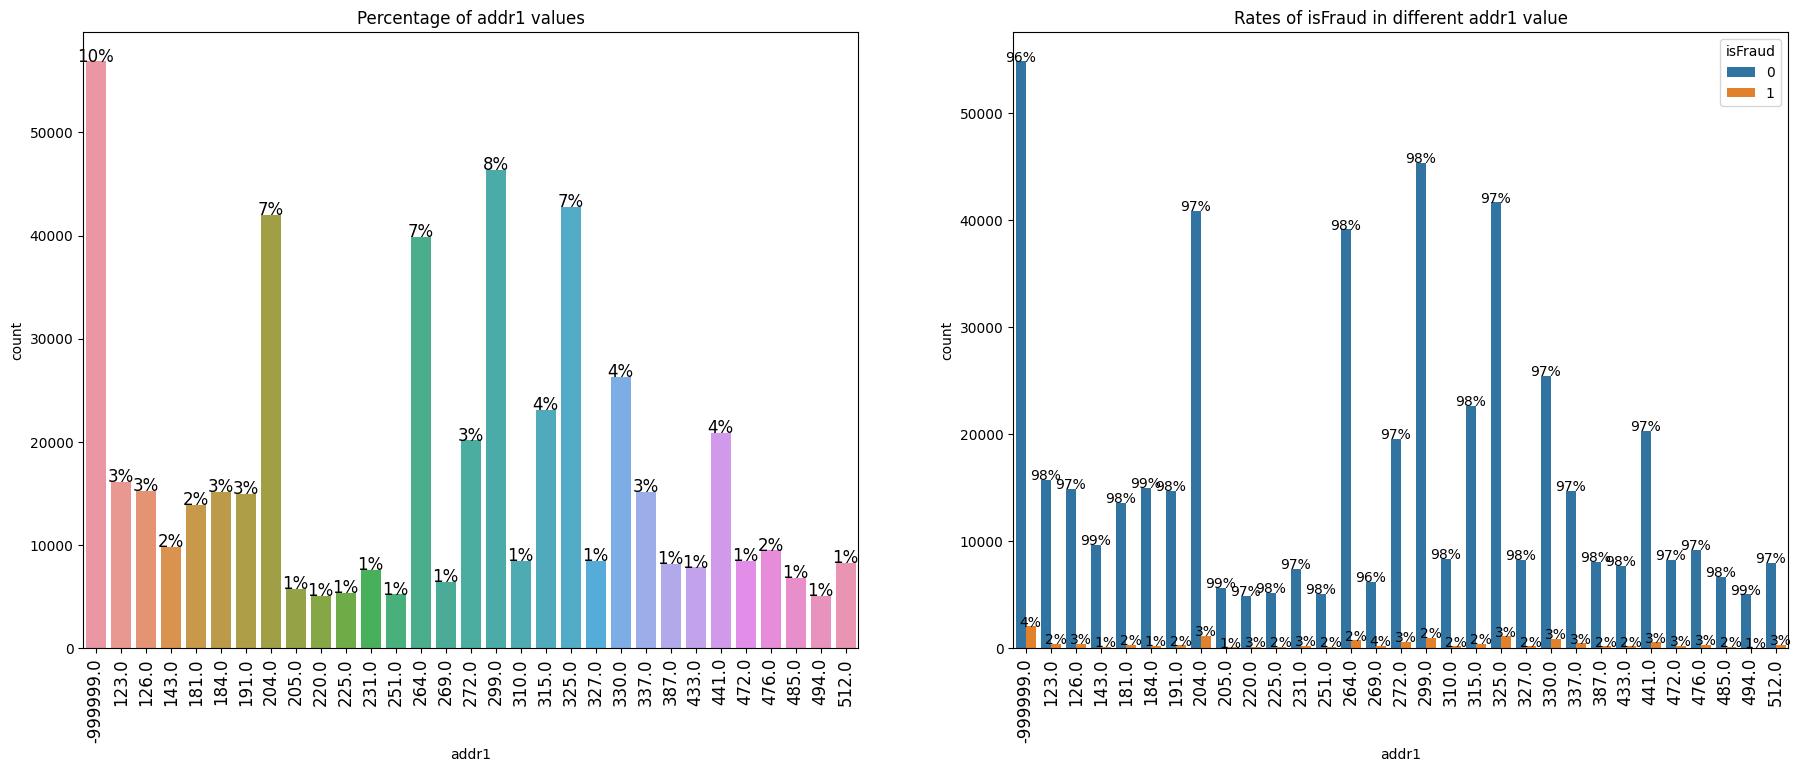

23019

In [28]:
col_list = train_df['addr1'].value_counts()[train_df['addr1'].value_counts() < 5000]
temp_df = train_df.loc[:,['addr1','isFraud']].copy()
temp_df['addr1'] = temp_df['addr1'].apply(lambda x :  -999999 if x in list(col_list.index) else x)

Plot_Cate_Feature(data = temp_df, col = 'addr1',corr_col='isFraud')
del col_list, temp_df
gc.collect()

Nothing important to be found

## addr2

The total Nan amount is 65706
The Nan rate is 11%


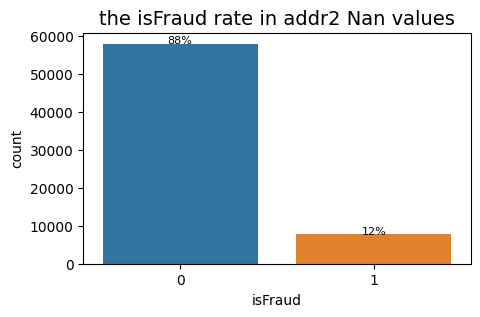

In [29]:
Plot_Feature_Nan_Rate(data = train_df, col = 'addr2', label = 'isFraud')

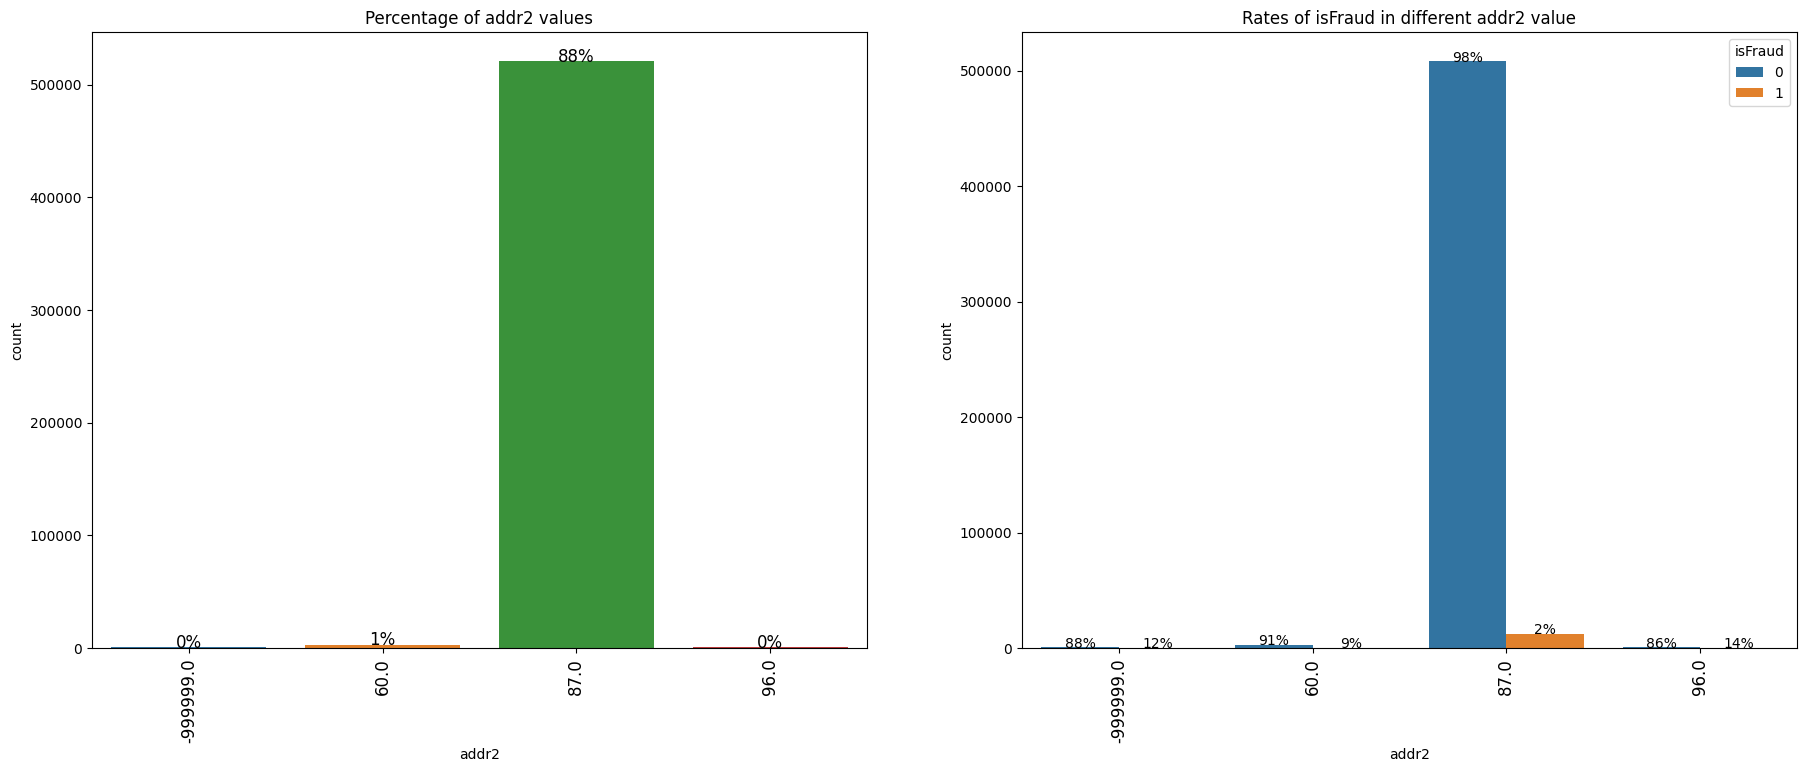

9288

In [30]:
col_list = train_df['addr2'].value_counts()[train_df['addr2'].value_counts() < 500]
temp_df = train_df.loc[:,['addr2', 'isFraud']].copy()

temp_df['addr2'] = temp_df['addr2'].apply(lambda x : -999999 if x in list(col_list.index) else x)
Plot_Cate_Feature(data=temp_df, col='addr2', corr_col='isFraud')

del col_list, temp_df
gc.collect()

According to images above, we can classify values of feature addr2 as -999999 except 87

Because fraud in value 87 is lower than other values of addr2.

Other values all have a high fraud rate

## card1

In [31]:
Plot_Feature_Nan_Rate(data = train_df, col = 'card1', label='isFraud')

There is no Nan value in card1


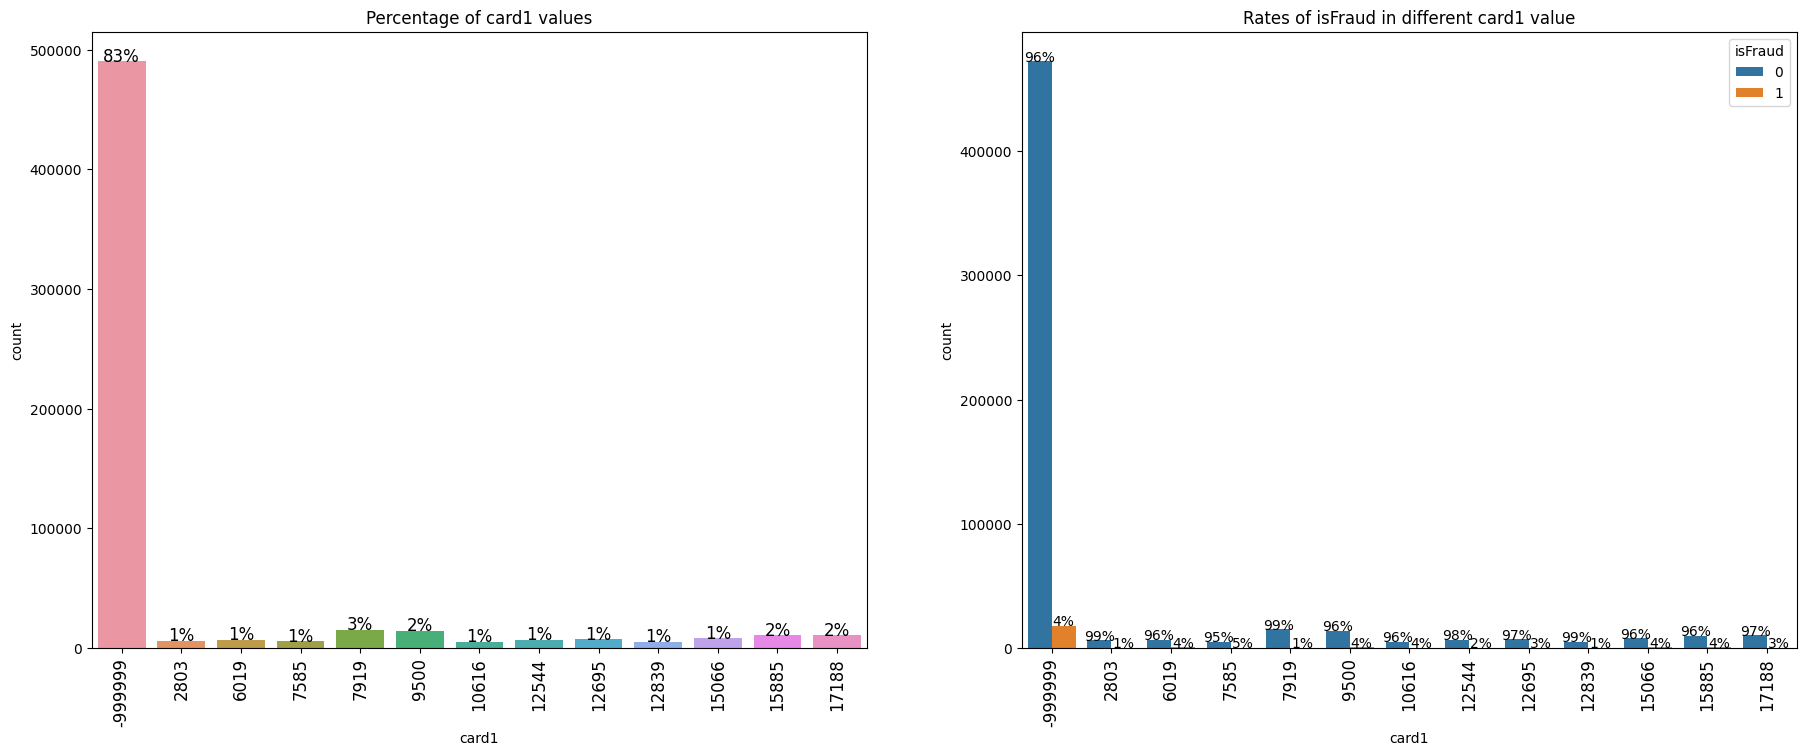

18760

In [41]:
col_list_Index = list(train_df['card1'].value_counts()[train_df['card1'].value_counts() < 5000].index)
temp_df = train_df.loc[:, ['card1','isFraud']].copy()

temp_df['card1'] = temp_df['card1'].apply(lambda x: -999999 if x in col_list_Index else x)
Plot_Cate_Feature(data = temp_df, col = 'card1', corr_col='isFraud')

del col_list_Index, temp_df
gc.collect()

- values of card1 are all small, if we set a threshold to do a classification. The new value may take a very high percentage of all values

- although we make a new classification and get a

In [40]:
train_df['card1'].value_counts()

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
12695     7091
12544     6773
6019      6771
2803      6141
7585      5334
10616     5172
12839     5129
3154      4614
2616      4410
18132     4209
9633      4158
15497     3977
16132     3929
2884      3873
16075     3748
11207     3693
10112     3560
7508      3490
10057     3166
12501     3152
7826      3006
16659     2988
12577     2891
5812      2818
7664      2792
7861      2774
6530      2714
4461      2686
8320      2632
5033      2604
7207      2578
15063     2522
10486     2505
10023     2428
7815      2411
9112      2364
16560     2080
9026      2076
16136     2069
4806      2067
13832     2062
7676      2038
12932     1998
1444      1964
4436      1947
11839     1940
17399     1916
2772      1898
2455      1799
1675      1790
14290     1767
11157     1722
3821      1681
17055     1677
1893      1651
1974      1591
17131     1587
18018     1569
1724      1567
9803      1538
8528      1523
2392      

In [39]:
print(cate_col_list, end = '')

['ProductCD', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo', 'addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']